In [1]:
# ==========================================
# SECTION 1: SETUP & IMPORTS
# ==========================================
# Uncomment the line below if running in Google Colab or a fresh environment
# !pip install torch torchvision numpy scipy matplotlib pandas opencv-python-headless tqdm

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better UI

# Create directories for outputs
os.makedirs("data/images", exist_ok=True)
os.makedirs("models", exist_ok=True)

print("Libraries loaded and directories created.")

Libraries loaded and directories created.


In [2]:
# ==========================================
# SECTION 2: PHYSICS MODULES (Zernike & Simulation)
# ==========================================

from scipy.fft import fftfreq # Ensure this import is present

def zernike_cartesian(x, y, n, m):
    """Calculates Zernike polynomial Z(n, m) at (x, y)."""
    if (n - m) % 2 != 0: return np.zeros_like(x)
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    rho[rho > 1] = 0
    R = 0
    if n >= abs(m):
        for k in range((n - abs(m)) // 2 + 1):
            R += ((-1)**k * np.math.factorial(n - k) * rho**(n - 2*k)) / \
                 (np.math.factorial(k) * np.math.factorial((n + abs(m)) // 2 - k) * \
                  np.math.factorial((n - abs(m)) // 2 - k))
    if m >= 0: Z = R * np.cos(m * theta)
    else: Z = R * np.sin(abs(m) * theta)
    if n == 0: Z = np.ones_like(x)
    Z *= np.sqrt(n + 1) # Norm
    if m != 0: Z *= np.sqrt(2)
    Z[rho > 1] = 0
    return Z

def get_zernike_basis(n_modes, grid_shape):
    """Generates basis of Zernike polynomials."""
    x = np.linspace(-1, 1, grid_shape[1])
    y = np.linspace(-1, 1, grid_shape[0])
    xx, yy = np.meshgrid(x, y)
    noll_nm = [(0,0), (1,1), (1,-1), (2,0), (2,-2), (2,2), (3,-1), (3,1), (3,-3), (3,3), (4,0), (4,-2), (4,2), (4,-4), (4,4)]
    basis = []
    for j in range(n_modes):
        n, m = noll_nm[j] if j < len(noll_nm) else (0,0)
        basis.append(zernike_cartesian(xx, yy, n, m))
    return basis

def create_vortex_beam(grid_shape, charge=1):
    y, x = np.indices(grid_shape)
    cy, cx = (grid_shape[0]-1)/2, (grid_shape[1]-1)/2
    rho = np.sqrt((x-cx)**2 + (y-cy)**2)
    theta = np.arctan2(y-cy, x-cx)
    w0 = grid_shape[1] / 6
    beam = (rho/w0)**abs(charge) * np.exp(-(rho**2)/w0**2) * np.exp(1j * charge * theta)
    return beam / np.max(np.abs(beam))

def create_aniso_phase_screen(grid_shape, power_law, mu_x, mu_y, strength):
    ky = fftshift(np.fft.fftfreq(grid_shape[0]))
    kx = fftshift(np.fft.fftfreq(grid_shape[1]))
    Kx, Ky = np.meshgrid(kx, ky)
    K_aniso_sq = (mu_x**2 * Kx**2) + (mu_y**2 * Ky**2)
    K_aniso_sq[K_aniso_sq == 0] = 1e-12
    power_spec = K_aniso_sq ** (-power_law / 2.0)
    noise = (np.random.randn(*grid_shape) + 1j * np.random.randn(*grid_shape))
    return np.real(ifft2(ifftshift(noise * np.sqrt(strength * 0.033 * power_spec))))

def propagate_beam(beam, phase_screen, distance=200):
    """
    Propagates the beam through the screen and then through free space
    so phase errors become intensity errors (scintillation).
    """
    # 1. Apply Phase Screen (Thin lens approximation)
    field = beam * np.exp(1j * phase_screen)

    # 2. Free Space Propagation (Angular Spectrum Method)
    # Parameters for the simulation scale
    wavelength = 633e-9  # Red HeNe laser
    side_length = 0.3    # 30 cm grid
    N = beam.shape[0]
    dx = side_length / N

    # Frequency grid
    fx = fftfreq(N, d=dx)
    fy = fftfreq(N, d=dx)
    FX, FY = np.meshgrid(fx, fy)

    # Shift zero frequency to center to match the beam format
    FX = fftshift(FX)
    FY = fftshift(FY)

    # Propagation Kernel (The "Transfer Function" of free space)
    # H = exp(-i * pi * lambda * z * (fx^2 + fy^2))
    H = np.exp(-1j * np.pi * wavelength * distance * (FX**2 + FY**2))

    # FFT -> Multiply Kernel -> IFFT
    field_ft = fft2(field)
    field_prop = ifft2(field_ft * H)

    return field_prop

def get_zernike_coeffs(phase_screen, basis):
    flat_screen = phase_screen.flatten()
    flat_basis = np.array([z.flatten() for z in basis]).T
    coeffs, _, _, _ = np.linalg.lstsq(flat_basis, flat_screen, rcond=None)
    return coeffs

def get_intensity_image(beam):
    intensity = np.abs(beam)**2
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min() + 1e-8)
    return (intensity * 255).astype(np.uint8)

print("Physics modules defined.")

Physics modules defined.


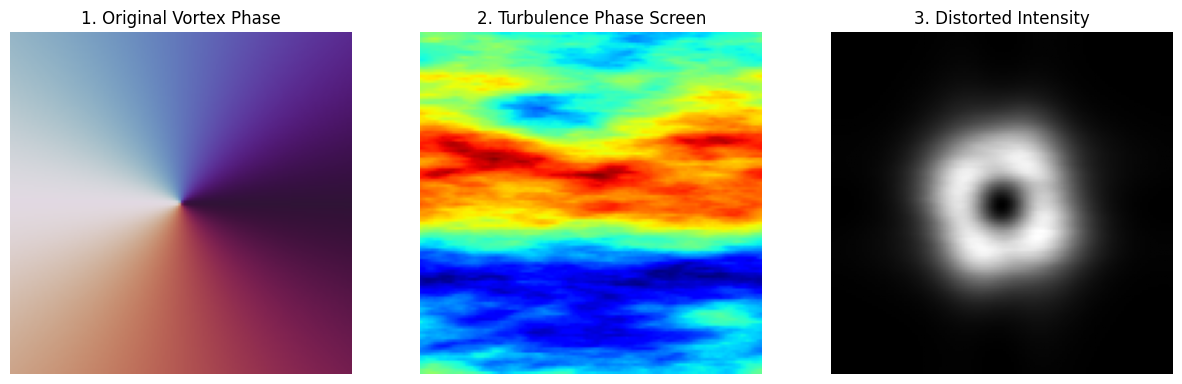

Simulation demo complete. Image saved as 'simulation_demo.png'.


In [3]:
# ==========================================
# SECTION 3: SIMULATION DEMO (The "Physical Schematic")
# ==========================================

# 1. Create Beam
GRID_SHAPE = (128, 128)
beam = create_vortex_beam(GRID_SHAPE, charge=1)

# 2. Create Turbulence (Anisotropic)
# alpha=3.6, mu_x=5.0 (stretched), strength=2.0
screen = create_aniso_phase_screen(GRID_SHAPE, 3.6, 5.0, 1.0, 2.0)

# 3. Propagate
distorted = propagate_beam(beam, screen)
intensity = get_intensity_image(distorted)

# 4. Visualize & Save
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(np.angle(beam), cmap='twilight'); plt.title("1. Original Vortex Phase"); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(screen, cmap='jet'); plt.title("2. Turbulence Phase Screen"); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(intensity, cmap='gray'); plt.title("3. Distorted Intensity"); plt.axis('off')
plt.savefig('simulation_demo.png') # Output for Report
plt.show()
print("Simulation demo complete. Image saved as 'simulation_demo.png'.")

In [4]:
# ==========================================
# SECTION 4: DATA GENERATION
# ==========================================

import math # Added this import

# --- Redefining PHYSICS MODULES (Zernike functions) to fix np.math.factorial error ---
# This redefinition is necessary because the original definition in SECTION 2
# contains an error, and the fix must be applied within the scope of this cell.

def zernike_cartesian(x, y, n, m):
    """Calculates Zernike polynomial Z(n, m) at (x, y)."""
    if (n - m) % 2 != 0: return np.zeros_like(x)
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    rho[rho > 1] = 0
    R = 0
    if n >= abs(m):
        for k in range((n - abs(m)) // 2 + 1):
            # FIXED: Changed np.math.factorial to math.factorial
            R += ((-1)**k * math.factorial(n - k) * rho**(n - 2*k)) / \
                 (math.factorial(k) * math.factorial((n + abs(m)) // 2 - k) * \
                  math.factorial((n - abs(m)) // 2 - k))
    if m >= 0: Z = R * np.cos(m * theta)
    else: Z = R * np.sin(abs(m) * theta)
    if n == 0: Z = np.ones_like(x)
    Z *= np.sqrt(n + 1) # Norm
    if m != 0: Z *= np.sqrt(2)
    Z[rho > 1] = 0
    return Z

def get_zernike_basis(n_modes, grid_shape):
    """Generates basis of Zernike polynomials."""
    x = np.linspace(-1, 1, grid_shape[1])
    y = np.linspace(-1, 1, grid_shape[0])
    xx, yy = np.meshgrid(x, y)
    noll_nm = [(0,0), (1,1), (1,-1), (2,0), (2,-2), (2,2), (3,-1), (3,1), (3,-3), (3,3), (4,0), (4,-2), (4,2), (4,-4), (4,4)]
    basis = []
    for j in range(n_modes):
        n, m = noll_nm[j] if j < len(noll_nm) else (0,0)
        basis.append(zernike_cartesian(xx, yy, n, m))
    return basis

# --- End of redefinition ---


def generate_dataset_inline(n_samples=1000):
    N_MODES = 15
    basis = get_zernike_basis(N_MODES, GRID_SHAPE) # This will now call the redefined get_zernike_basis
    data = []

    print(f"Generating {n_samples} samples...")
    for i in tqdm(range(n_samples)):
        # Randomize turbulence parameters
        alpha = np.random.uniform(3.0, 4.0)
        mu_x = np.random.uniform(1.0, 5.0)
        mu_y = np.random.uniform(1.0, 5.0) # Added randomization for mu_y
        strength = np.random.uniform(1.0, 7.0) # Increased strength range for more diversity

        # Run Physics
        # Updated call to create_aniso_phase_screen to include randomized mu_y
        screen = create_aniso_phase_screen(GRID_SHAPE, alpha, mu_x, mu_y, strength)
        distorted = propagate_beam(beam, screen)
        img = get_intensity_image(distorted)
        coeffs = get_zernike_coeffs(screen, basis)[1:] # Get coeffs (skip piston)

        # Save
        fname = f"beam_{i:05d}.png"
        Image.fromarray(img).save(f"data/images/{fname}")
        data.append([fname] + list(coeffs))

    # Save CSV
    cols = ["filename"] + [f"z{j+1}" for j in range(1, N_MODES)]
    pd.DataFrame(data, columns=cols).to_csv("data/labels.csv", index=False)
    print("Dataset generation complete.")

# Run Data Generation
generate_dataset_inline(n_samples=1000)

Generating 1000 samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset generation complete.


In [5]:
# ==========================================
# SECTION 5: MODEL & DATASET DEFINITION
# ==========================================

class TurbulenceDataset(Dataset):
    def __init__(self, img_dir, label_file):
        self.img_dir = img_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        fname = self.labels.iloc[idx, 0]
        img = Image.open(os.path.join(self.img_dir, fname)).convert('L')
        y = self.labels.iloc[idx, 1:].values.astype('float32')
        return self.transform(img), torch.tensor(y)

class CompensationNet(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        # Load ResNet34
        self.resnet = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        # Modify first layer for 1 channel instead of 3 (RGB)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify last layer for regression (num_outputs)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_outputs)

    def forward(self, x):
        return self.resnet(x)

print("Model and Dataset classes defined.")

Model and Dataset classes defined.


Training on device: cpu
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 150MB/s]


Epoch 1/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.0145, Val Loss=0.1295


Epoch 2/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.0005, Val Loss=0.0291


Epoch 3/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.0003, Val Loss=0.0046


Epoch 4/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.0002, Val Loss=0.0005


Epoch 5/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0002, Val Loss=0.0005


Epoch 6/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0002, Val Loss=0.0004


Epoch 7/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0002, Val Loss=0.0004


Epoch 8/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0002, Val Loss=0.0005


Epoch 9/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0002, Val Loss=0.0004


Epoch 10/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0002, Val Loss=0.0003


Epoch 11/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.0002, Val Loss=0.0004


Epoch 12/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0002, Val Loss=0.0004


Epoch 13/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.0001, Val Loss=0.0003


Epoch 14/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.0002, Val Loss=0.0004


Epoch 15/15:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.0002, Val Loss=0.0004


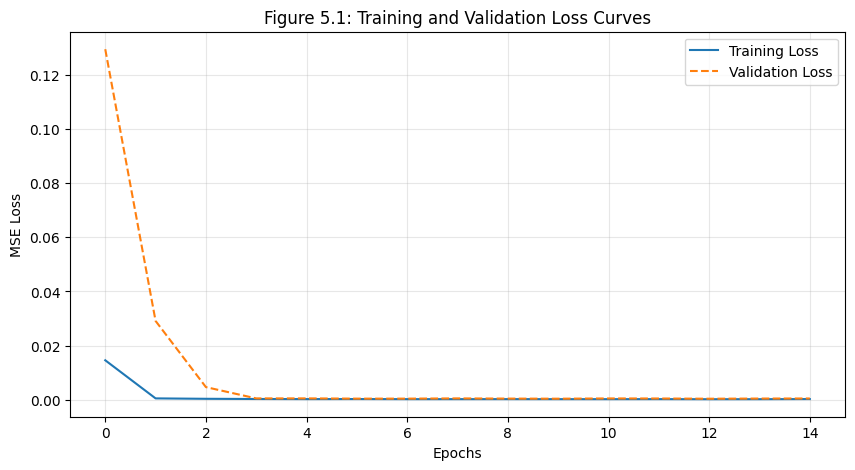

Training complete. Model saved.


In [6]:
# ==========================================
# SECTION 6: TRAINING LOOP
# ==========================================

def train_model_inline():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Setup Data
    dataset = TurbulenceDataset("data/images", "data/labels.csv")
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=32)

    # Setup Model
    model = CompensationNet(14).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    history = {'train': [], 'val': []}

    # Training Loop
    epochs = 15
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                val_loss += criterion(model(x.to(device)), y.to(device)).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        history['train'].append(avg_train)
        history['val'].append(avg_val)
        print(f"Epoch {epoch+1}: Train Loss={avg_train:.4f}, Val Loss={avg_val:.4f}")

    # Save Results
    torch.save(model.state_dict(), "models/compensation_model.pth")

    plt.figure(figsize=(10,5))
    plt.plot(history['train'], label='Training Loss')
    plt.plot(history['val'], label='Validation Loss', linestyle='--')
    plt.title("Figure 5.1: Training and Validation Loss Curves")
    plt.xlabel("Epochs"); plt.ylabel("MSE Loss")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.savefig('training_loss.png') # Output for Report
    plt.show()
    print("Training complete. Model saved.")
    return model

# Run Training
trained_model = train_model_inline()

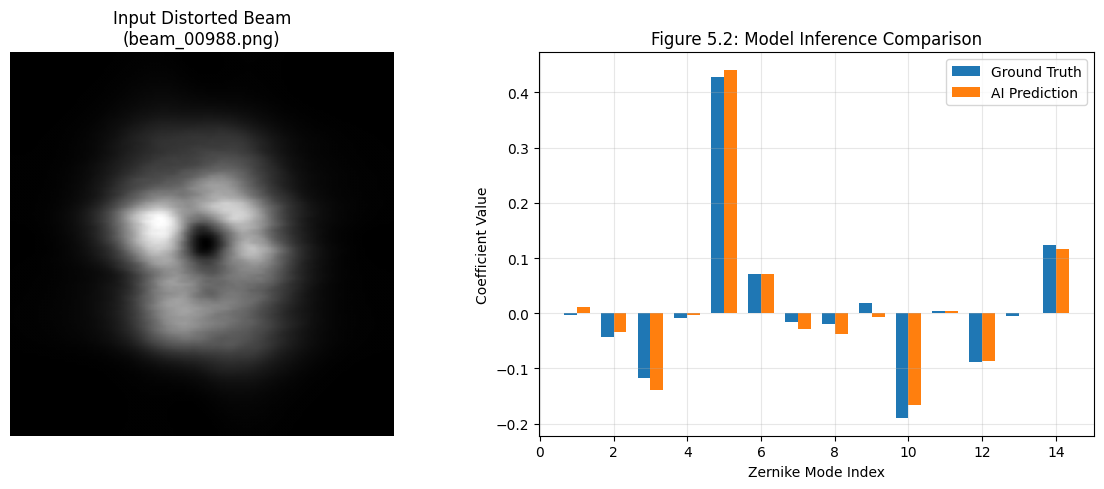

Generating scatter plot on validation batch...


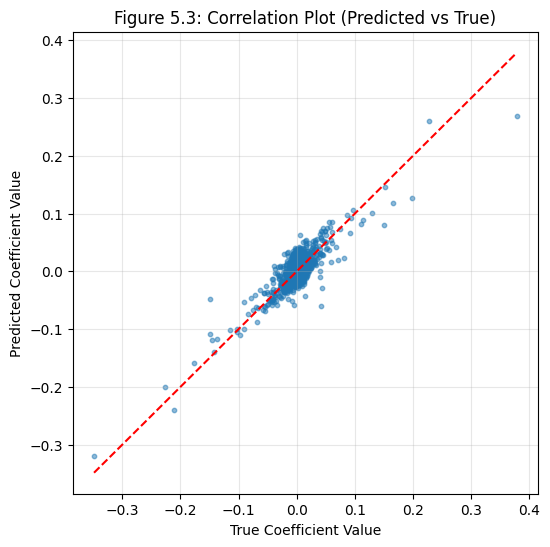

In [7]:
# ==========================================
# SECTION 7: INFERENCE & VISUALIZATION
# ==========================================

def run_inference_inline(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Load a random sample from the CSV
    df = pd.read_csv('data/labels.csv')
    row = df.sample(1).iloc[0]
    img_path = f"data/images/{row['filename']}"
    true_coeffs = row[1:].values.astype('float')

    # Prepare image
    img = Image.open(img_path).convert('L')
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    input_tensor = tf(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        pred_coeffs = model(input_tensor).cpu().numpy().flatten()

    # Plot Comparison (Figure 5.2 Style)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Input Distorted Beam\n({row['filename']})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    x = np.arange(1, 15)
    width = 0.35
    plt.bar(x - width/2, true_coeffs, width, label='Ground Truth')
    plt.bar(x + width/2, pred_coeffs, width, label='AI Prediction')
    plt.xlabel('Zernike Mode Index')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.title('Figure 5.2: Model Inference Comparison')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('inference_result.png') # Output for Report
    plt.show()

    # Scatter Plot (Figure 5.3 Style)
    # To make a good scatter plot, we need predictions on many images
    print("Generating scatter plot on validation batch...")
    dataset = TurbulenceDataset("data/images", "data/labels.csv")
    loader = DataLoader(dataset, batch_size=100, shuffle=True)

    all_preds = []
    all_trues = []

    with torch.no_grad():
        # Get one batch of 100 images
        images, labels = next(iter(loader))
        preds = model(images.to(device)).cpu().numpy()
        trues = labels.numpy()

        all_preds.extend(preds.flatten())
        all_trues.extend(trues.flatten())

    plt.figure(figsize=(6, 6))
    plt.scatter(all_trues, all_preds, alpha=0.5, s=10)
    plt.plot([min(all_trues), max(all_trues)], [min(all_trues), max(all_trues)], 'r--')
    plt.xlabel('True Coefficient Value')
    plt.ylabel('Predicted Coefficient Value')
    plt.title('Figure 5.3: Correlation Plot (Predicted vs True)')
    plt.grid(True, alpha=0.3)
    plt.savefig('scatter_plot.png') # Output for Report
    plt.show()

# Run Inference
run_inference_inline(trained_model)